## Final Project Submission

Please fill out:
* Student name: Joe Wilkinson
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# OSEMN
Obtain - Scrub - Explore - Model - Interpret

We used the OSEMN framework to evaluate the King County housing data with the intent of building a model to predict house sales prices based on a variety of predictors. 

## Table of Contents

### [1. Obtain](#1)
1. [Project Discovery](#1.1)
2. [Library and Data Import](#1.2)

### [2. Scrub and Explore](#2)
1. [Subsample](#2.1)
2. [Dealing with Data Types](#2.2)
3. [Dealing with Null Values](#2.3)
4. [Check for Multicollinearity](#2.4)
5. [Normalize Data](#2.5)
6. [Creating visualizations](#2.6)

### [4. Model](#4)
1. [One - Hot - Encoding](#4.1)
2. [Regression](#4.2)
3. [Dimensionality Reduction](#4.3)
4. [Final Model](#4.4)


### [5. Interpret](#5) 

<a id="1"></a>
## Obtain

<a id="1.1"></a>
#### *Who are the stakeholders in this project? Who will be directly affected by the creation of this project?*

Potential Stakeholders: Real estate agents, home buyers, home sellers, investors, banks, insurance companies, IRS, real estate development companies

#### *What business problem(s) will this Data Science project solve for the organization? *

The model will help the business make decisions about where to buy lots and what to build to maximize their revenue.
*Try to incorporate construction costs to determine ROI 
http://www.nahbclassic.org/generic.aspx?genericContentID=260013/
https://www.fixr.com/costs/build-single-family-house#cQ

#### *What problems are inside the scope of this project?*

This project will determine a model that estimates the sale price of a house and determine which house features have the greatest effect on the sales price.

#### *What problems are outside the scope of this project?*

Determining ROI of each feature is outside the scope of this project. ROI must be determined on an case by case basis using the the architect's project cost estimates in conjunction with this model's price increase estimate.

#### *What data sources are available to us?*

King Count House Sales dataset is supplied to us in a CSV file. 

<a id="1.2"></a>
### Importing Libraries and Data

In [1]:
#imports and loading in data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline

# KC House Data will be used to build the model for the sales price
df = pd.read_csv('kc_house_data.csv')
df.head()

/Users/joe/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


*Cost of construction will be estimates based on national construction averages for single family homes adjusted for geographic price differences.*

<a id="2"></a>
## Scrub
<a id="2.1"></a>
### 1. Subsample
We took a subsample of the data to imporove run times and stored it in the variable 'df'. 

*To see the final results, comment out.*

In [3]:
# df = df.sample(frac=0.2, random_state=5)

<a id="2.2"></a>
### 2. Dealing with Datatypes 
When looking at the data we can see there are some problems with the datatypes you would expect from certain variables. Problems that I found were:

- Waterfront and zipcode are categorical variables that were stored as floats and ints respectively. 
- Sqft_basement, view and yr_renovated should be ints but couldn't be cast until null values were dealt with.
- We need to turn date into a numermerical column so that we can run statistics on it.

<a id="2.3"></a>
### 3. Dealing with Null Values
We chose to drop all rows that had null values in the view and sqft_basement columns. There was a low number of rows that were missing data.

For yr_renovated, we chose to replace all null and 0 values with the year that the house was built. Obviously, no house was renovated over 2000 years ago, so 0 values should equate to the house never having been renovated. Since there was a high number of rows that fit this filter, we couldn't drop the rows. Instead, we elected to replace it with the year the house was built, which is the last year there was major construction done on the house. 

In [4]:
# waterfront, zipcode are categorical data, so I cast them to category
# drop rows with null values
df = df[np.isfinite(df['waterfront'])]
df.zipcode = df.zipcode.astype('category')

# Waterfront is already 1's and 0's, so it just needs to be converted to ints
df.waterfront = df.waterfront.astype('int64')

# Drop any rows where view is NaN, there are a low number of NaN in that column
# View should be converted to binary category
df = df[np.isfinite(df['view'])]
df.view = df.view.where(df.view <= 0, other = 1)
df.view = df.view.astype('int64').astype('category')

# sqft_basedfment should be numerical
# Remove rows with '?' and cast to ints
df = df.loc[df['sqft_basement'] != '?']
df.sqft_basement = df.sqft_basement.astype('float64').astype('int64')

# yr_renovated: if 0.0 or Null, the value should equal the year built since that was the last time it was worked on
mask = ((np.isnan(df['yr_renovated'])) | (df['yr_renovated'] == 0))
column_name = 'yr_renovated'
df.loc[mask, column_name] = df.yr_built
df.yr_renovated = df.yr_renovated.astype('int64')

# Date needs to be converted to a numerical value so that we can run statistics on it
df['date'] = pd.to_datetime(df['date'])
df['date'] = (pd.to_datetime('today') - df['date']).dt.days

Now that we have dealth with each of the problematic columns, we want to double check that the data is clean and ready to use.

In [5]:
# Check column details for any remaining null values or incorrect datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18749 entries, 1 to 21596
Data columns (total 21 columns):
id               18749 non-null int64
date             18749 non-null int64
price            18749 non-null float64
bedrooms         18749 non-null int64
bathrooms        18749 non-null float64
sqft_living      18749 non-null int64
sqft_lot         18749 non-null int64
floors           18749 non-null float64
waterfront       18749 non-null int64
view             18749 non-null category
condition        18749 non-null int64
grade            18749 non-null int64
sqft_above       18749 non-null int64
sqft_basement    18749 non-null int64
yr_built         18749 non-null int64
yr_renovated     18749 non-null int64
zipcode          18749 non-null category
lat              18749 non-null float64
long             18749 non-null float64
sqft_living15    18749 non-null int64
sqft_lot15       18749 non-null int64
dtypes: category(2), float64(5), int64(14)
memory usage: 3.5 MB


<a id="2.4"></a>
### 4. Check for Multicollinearity

**Question** *Are there any features that are too highly correlated to be sure how it describes our dependent variable?*

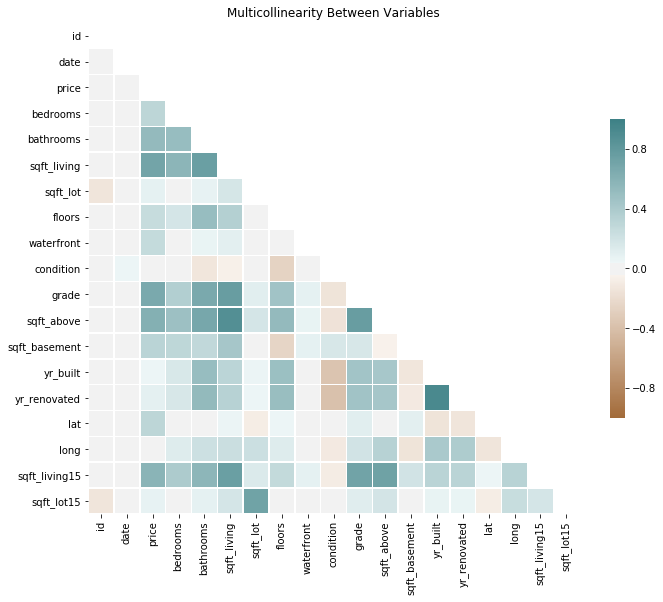

In [6]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(400, 200, as_cmap=True)
ax.set_title('Multicollinearity Between Variables')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The graph above does a great job of very quickly showing us where multicolinearity exists and to what degree. Looking at the graph we can see that there are going to be a couple variables that will make it difficult to see the effect on the dependent variable. To get an absolute answer to our question, we can print out a similar matrix that shows us which variables have a pairwise correlation of 0.75 or higher, meaning they are significantly correlated.

In [7]:
df.corr()
abs(df.corr()) >= 0.75
# Show all pairwise correlations above .75

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


### Results
*Using absolute correlation of >= .75 as the cutoff*
Any columns that have a pairwise correlation of 0.75 or higher will need to drop columns to make sure only one is left in our dataset. This allows us to be certain that we aren't overstating the effect of a single predictor on our dependent variable.

**Columns with high correlation:**
- sqft_living, sqft_above and grade
- bathrooms, sqft_living\*
- sqft_lot and sqft_lot15
- yr_built and year_renovated


#### sqft_living - sqft_above - grade
We'll drop grade because it is the most subjective of the three. Because sqft_living is sqft_above + sqft_basement, we're going to drop the sqft_living. This will give us more granularity in our predictors while still eliminating our multicollinearity problem.

#### sqft_living - bathrooms
Since we already dropped sqft_living for the above mulicolinearity problem, we have already solved this one.

#### sqft_lot - sqft_lot15
This makes sense that a neighborhood would have similar lot sizes. We'll drop sqft_lot15 because it's the column that isn't specifically about the property in question.

#### yr_built - year_renovated
This likely is caused by the way I chose to to handle the zeros in the yr_renovated column. Since these columns are highly correlated, we'll drop yr_renovated since it's the transfored column.

Drop ID because it's an aribitrary identification number for a house

**DROP:**
- id
- grade
- sqft_living
- sqft_lot15
- yr_renovated


\**The bathrooms-sqft_living correlation does not exist in the subsample we took but does when ran with the full dataset.*

In [8]:
df.drop(['id', 'grade', 'sqft_living', 'sqft_lot15', 'yr_renovated'], axis=1, inplace=True)
df.describe()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15
count,18749.000000,1.874900e+04,18749.000000,18749.000000,1.874900e+04,18749.000000,18749.000000,18749.000000,18749.000000,18749.000000,18749.000000,18749.000000,18749.000000,18749.000000
mean,1627.735773,5.416223e+05,3.374207,2.117446,1.508526e+04,1.494666,0.007520,3.410049,1792.025975,290.675289,1971.065764,47.560170,-122.213928,1987.864419
std,113.126055,3.716492e+05,0.927399,0.769283,4.097762e+04,0.539928,0.086396,0.650349,832.398189,442.216056,29.324703,0.138735,0.140565,685.188038
min,1418.000000,7.800000e+04,1.000000,0.500000,5.200000e+02,1.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,47.155900,-122.519000,399.000000
25%,1517.000000,3.215000e+05,3.000000,1.750000,5.043000e+03,1.000000,0.000000,3.000000,1200.000000,0.000000,1952.000000,47.471100,-122.328000,1490.000000
50%,1641.000000,4.500000e+05,3.000000,2.250000,7.630000e+03,1.500000,0.000000,3.000000,1560.000000,0.000000,1975.000000,47.572200,-122.230000,1840.000000
75%,1727.000000,6.435000e+05,4.000000,2.500000,1.072300e+04,2.000000,0.000000,4.000000,2220.000000,560.000000,1997.000000,47.678200,-122.125000,2360.000000
max,1808.000000,7.700000e+06,33.000000,8.000000,1.651359e+06,3.500000,1.000000,5.000000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,6210.000000


**Question**: *How much variability is there from one zipcode to another?*

When looking at our data, we can see that there is a lot of different zipcodes in this dataset. Knowing that in real estate location plays a major factor in how expensive the house is, I wanted to get a closer look at the variability between zipcodes.

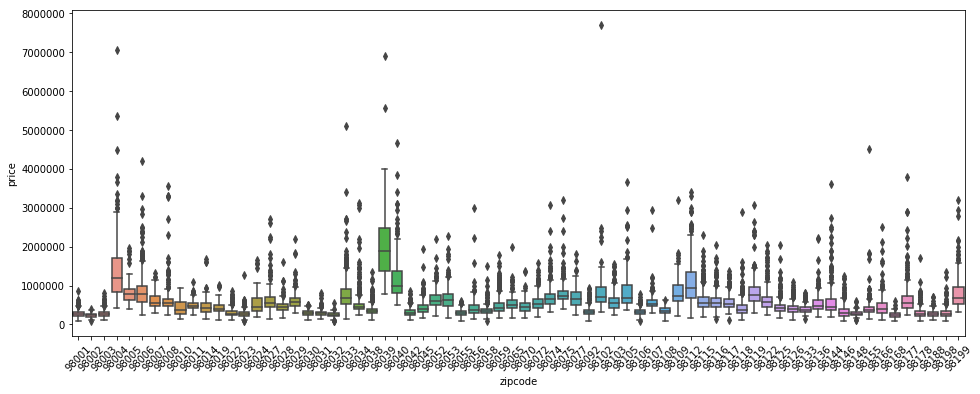

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
ax = sns.boxplot(ax=ax, x='zipcode', y='price', data=df, )
plt.setp(ax.get_xticklabels(), rotation=45)
plt.savefig('quantiles_by_zip.png')

The price ranges vary greatly from one zipcode to another. Additionally, there are a relatively small number of zipcodes that really stand out from the others in terms of the price in the upper quartiles.

<a id="2.5"></a>
### 5. Normalize Data
**Question:** *Are all of the features normally distributed?*

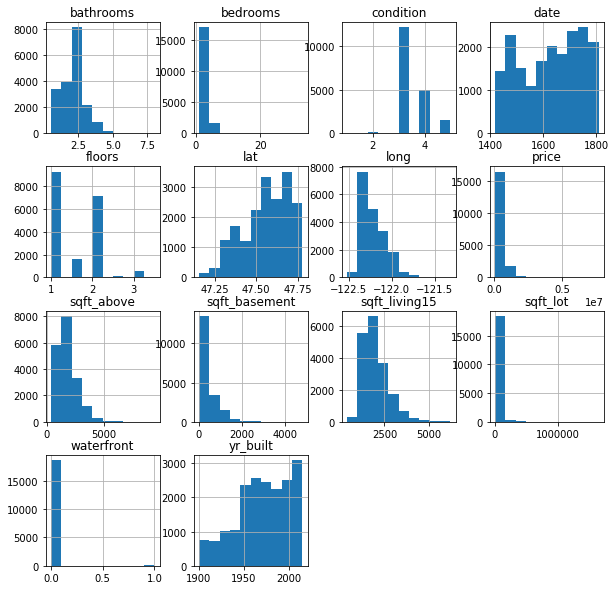

In [10]:
df.hist(figsize=(10,10))
plt.show()

Looks like most of the featrues are skewed. We'll need to log transform all numeric columns that show a certain level of skewness. 

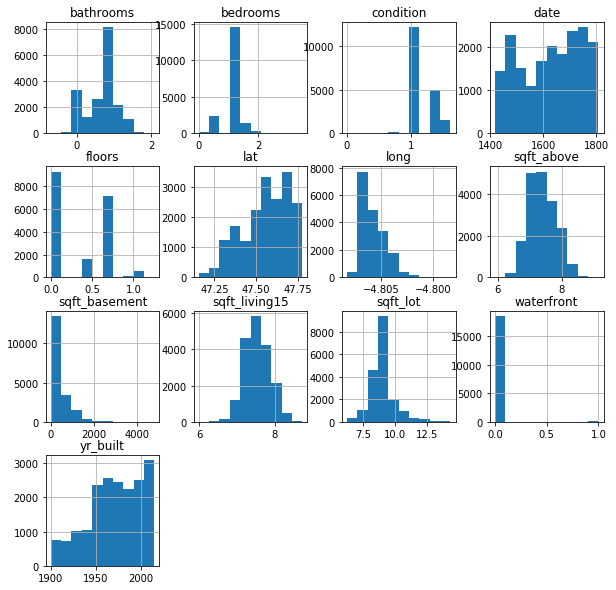

In [11]:
import scipy.stats as stats
# create variables for ind and dep variables and one to keep track of which variables are log transformed
ind_vars = df
dep_var = df['price']
ind_vars.drop(['price'], axis=1, inplace=True)
log_transformed = [] # Keep track of which variables were log transformed

for column in df.select_dtypes(include=['int64', 'float64']):
    # We want to log all columns that show signs of skewness
    if stats.skew(df[column]) >= 0.5 or stats.skew(df[column]) <= -0.5:
        """
        Can't log negative numbers. 
        All of of longitudes are negative, so we have to log the absolute value and then multiply by -1.
        """
        if column == 'long':
            ind_vars[column] = np.log(abs(df[column])) 
            ind_vars[column] = df[column] * -1 # Store in our independent variables df
            log_transformed.append(column)
            continue
        elif not df[column].isin([0]).any():
            ind_vars[column] = np.log(df[column]) # Store in our independent variables df
            log_transformed.append(column)
    else:
        ind_vars[column] = df[column] # add any now skewed columns to ind_vars without log

for column in df.select_dtypes(include=['category', 'object']):
    ind_vars[column] = df[column]

ind_vars.hist(figsize=(10,10))
plt.show()

While there is plenty of skewness left in the data, most of the features are looking much more normal. 

We want to make sure that our model tells us which predictors have the highest influence on our dependent variable and not which ones units require the largest numbers. So, to do that we will standardize our data. This will make sure that every data point is a numeric number which represents how far away it is from the mean in terms of standard deviations.

In [12]:
# store mean and std for all log transformed variables
pre_standardization = []
# Standardize numeric columns
for column in ind_vars.select_dtypes(include=['int64', 'float64']):
    if column != 'price':
        result = [column]
        result.append(ind_vars[column].mean())
        result.append(ind_vars[column].std())
        pre_standardization.append(result)
        ind_vars[column] = (ind_vars[column] - ind_vars[column].mean()) / ind_vars[column].std()
ind_vars.head()
print(pre_standardization)

[['date', 1627.7357725745374, 113.12605547822943], ['bedrooms', 1.178249344351182, 0.2826588747407695], ['bathrooms', 0.6785096431295167, 0.3921166451368754], ['sqft_lot', 8.99288878214391, 0.902433055286682], ['floors', 0.33880183367040223, 0.35247464966530995], ['waterfront', 0.00752040108805803, 0.08639584926206602], ['condition', 1.2098921719984412, 0.18105102354163063], ['sqft_above', 7.396501504209798, 0.42839781307464114], ['sqft_basement', 290.67528934876526, 442.2160557459678], ['yr_built', 1971.0657635073871, 29.32470338814676], ['lat', 47.56017039842128, 0.13873483127904035], ['long', -4.805772351528213, 0.0011507395328382724], ['sqft_living15', 7.5402665374182645, 0.32699127634701064]]


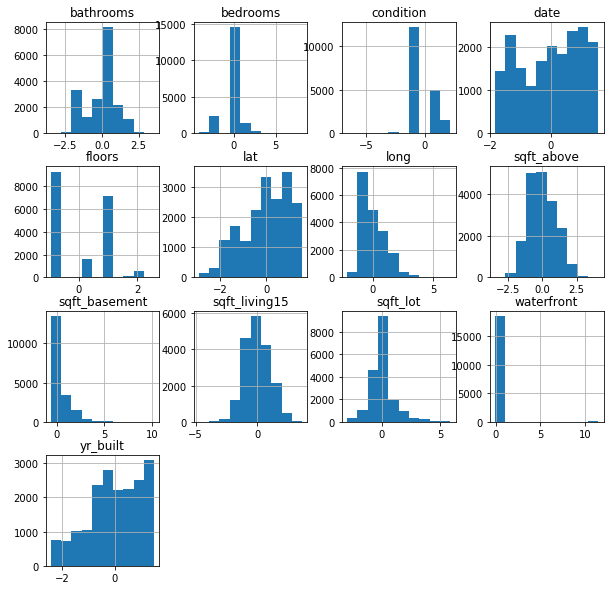

In [13]:
ind_vars.hist(figsize=(10,10))
plt.show()

<a id="2.6"></a>
### 2.6 Creating visualizations
We'll look at the joint plots for each of our independent variables mapped with the dependent variable. This will allow us to see the scatter plot, regression line and KDE plot in one visualization. 

Some of our independent variables had such concentrated clusters of data that it became very difficult to read the scatter plots. To fix this, we'll look at a the hex plot instead which shows higher density areas as a darker shade. This gives us a more realistic view of what we're looking at.

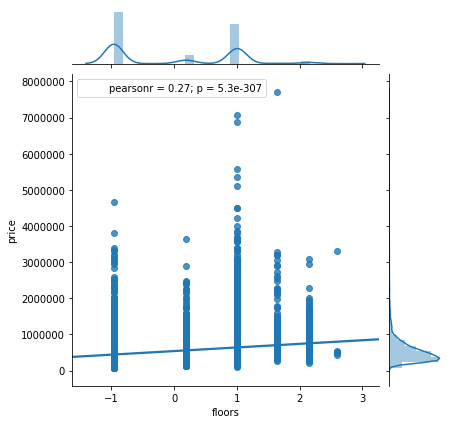

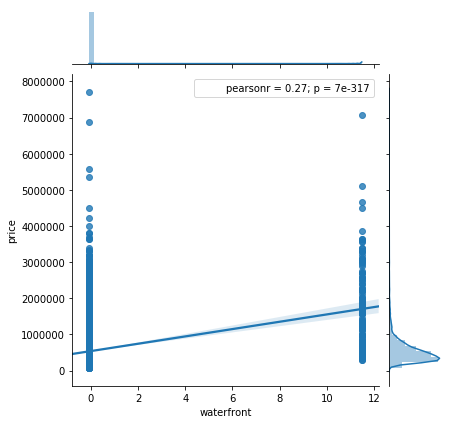

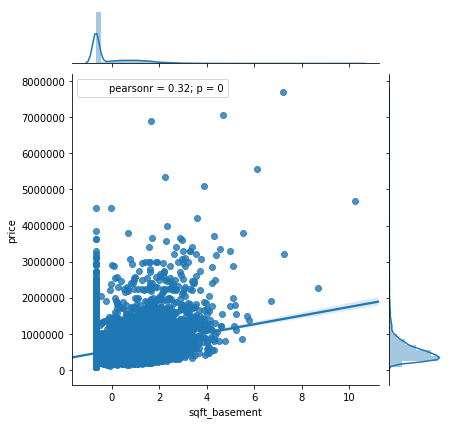

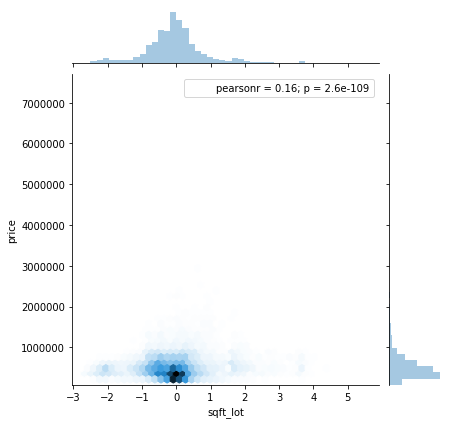

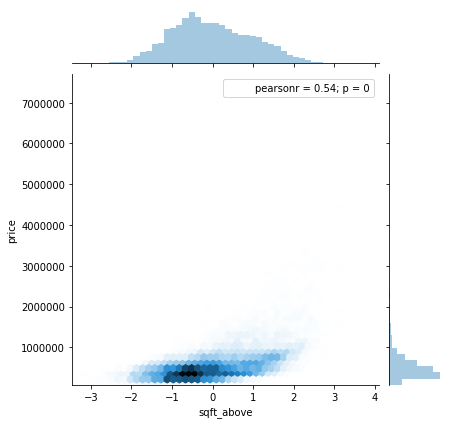

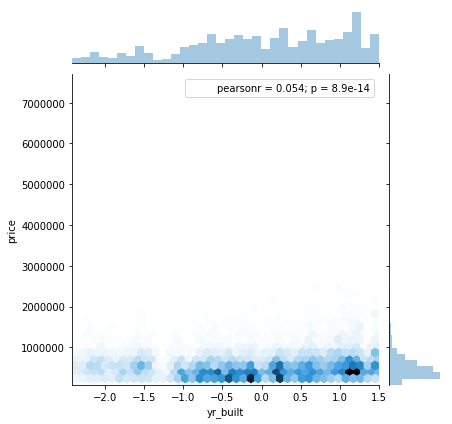

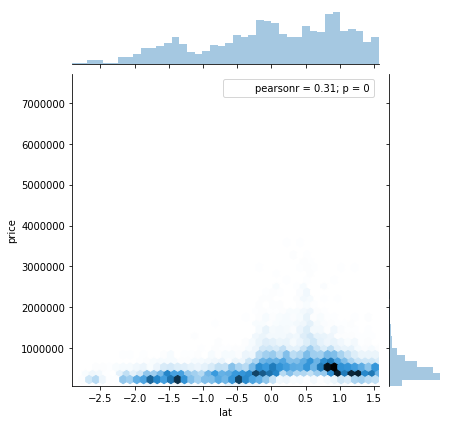

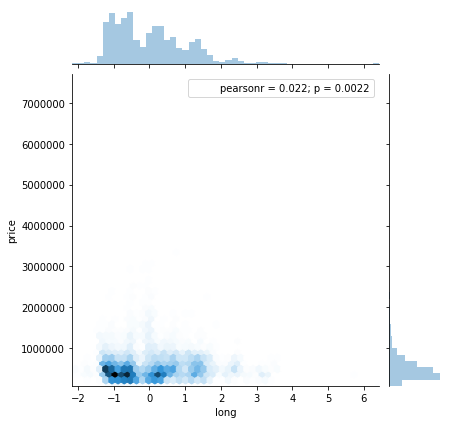

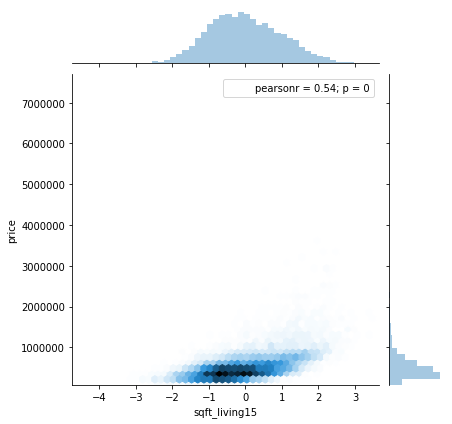

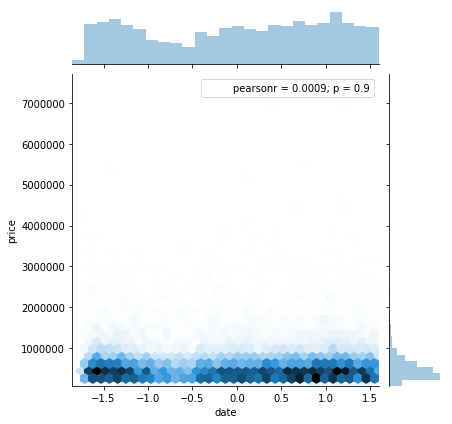

In [14]:
# Create jointplot for all independent variables
for column in list(ind_vars.select_dtypes(include=['int64', 'float64'])):
    if column not in ['bathrooms', 'bedrooms', 'condition', 'sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
        sns.jointplot(x=ind_vars[column], y=dep_var, kind='reg')
# Some independent variables needed to be a hex jointplot to show how the data is clustered more clearly
for column in ['sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
    sns.jointplot(x=ind_vars[column], y=dep_var, kind='hex')

<a id="4"></a>
## 4. Model
<a id="4.1"></a>
### 1. One Hot Encoding
To be able to run numerical calculations on categorical columns, we have to one-hot-encode them. This turns each unique value into it's own column of 1's and 0's. 

In [15]:
zips = pd.get_dummies(ind_vars.zipcode)
ind_vars = df.join(zips)
ind_vars.drop(['zipcode'], axis=1, inplace=True)
ind_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18749 entries, 1 to 21596
Data columns (total 84 columns):
date             18749 non-null float64
bedrooms         18749 non-null float64
bathrooms        18749 non-null float64
sqft_lot         18749 non-null float64
floors           18749 non-null float64
waterfront       18749 non-null float64
view             18749 non-null category
condition        18749 non-null float64
sqft_above       18749 non-null float64
sqft_basement    18749 non-null float64
yr_built         18749 non-null float64
lat              18749 non-null float64
long             18749 non-null float64
sqft_living15    18749 non-null float64
98001            18749 non-null uint8
98002            18749 non-null uint8
98003            18749 non-null uint8
98004            18749 non-null uint8
98005            18749 non-null uint8
98006            18749 non-null uint8
98007            18749 non-null uint8
98008            18749 non-null uint8
98010            18749 non

In [16]:
ind_vars.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
1,-0.360092,-0.281743,0.337707,-0.116614,1.005307,-0.087046,0,-0.614633,0.667559,0.247220,...,0,0,0,0,0,0,0,0,0,0
2,-1.049588,-1.716211,-1.730377,0.240961,-0.961209,-0.087046,0,-0.614633,-1.750968,-0.657315,...,0,0,0,0,0,0,0,0,0,0
3,-0.360092,0.736029,1.071372,-0.527126,-0.961209,-0.087046,0,2.206813,-1.026980,1.400503,...,0,0,0,0,0,0,0,0,0,0
4,-0.987710,-0.281743,0.037330,0.004719,-0.961209,-0.087046,0,-0.614633,0.070139,-0.657315,...,0,0,0,0,0,0,0,0,0,0
5,1.505084,0.736029,2.105414,2.813674,-0.961209,-0.087046,0,-0.614633,2.030036,2.802532,...,0,0,0,0,0,0,0,0,0,0


<a id="4.2"></a>
### 2. Regression
To build the most predictive model that we can, we'll look at a few diffent transformations and how that effects the predicitability of the model. First we'll start with our scrubbed and cleaned data with an unaltered `price` dependent variable.

In [17]:
ind_vars.view = ind_vars.view.astype('uint8')
X = ind_vars
y = dep_var
y_log = np.log(y)
X = sm.add_constant(X)

# fit a linear model for our data
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     672.5
Date:                Sun, 14 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:54:05   Log-Likelihood:            -2.5410e+05
No. Observations:               18749   AIC:                         5.084e+05
Df Residuals:                   18665   BIC:                         5.090e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.35e+05   1735.640    308.246      0.000    5.32e+05    5.38e+05
date          -1.245e+04   1368.495     -9.100      0.000   -1.51e+04   -9770.524
bedrooms       -3.27e+04   1853.937    -17.638      0.000   -3.63e+04   -2.91e+04
bathrooms      6808.7678   2460.211      2.768      0.006    1986.531    1.16e+04
sqft_lot       3.751e+04   2096.446     17.894      0.000    3.34e+04    4.16e+04
floors        -2939.8610   2258.915     -1.301      0.193   -7367.540    1487.818
waterfront     7.036e+04   1444.119     48.722      0.000    6.75e+04    7.32e+04
view            1.34e+05   5339.745     25.095      0.000    1.24e+05    1.44e+05
condition      1.402e+04   1528.522      9.172      0.000     1.1e+04     1.7e+04
sqft_above     1.842e+05   3006.787     61.246      0.000    1.78e+05     1.9e+05
sqft_basement  7.136e+04   1896.196     37.632      0.000    6.76e+04    7.51e+04
yr_built       4968.2930   2195.131      2.263      0.024     665.636    9270.950
lat            3.833e+04   1.09e+04      3.502      0.000    1.69e+04    5.98e+04
long          -2.435e+04   8051.239     -3.024      0.002   -4.01e+04   -8568.498
sqft_living15  2.057e+04   2316.432      8.879      0.000     1.6e+04    2.51e+04
98001         -1.795e+05   2.24e+04     -8.001      0.000   -2.24e+05   -1.36e+05
98002         -1.277e+05   2.38e+04     -5.365      0.000   -1.74e+05    -8.1e+04
98003         -1.813e+05   2.32e+04     -7.816      0.000   -2.27e+05   -1.36e+05
98004          6.208e+05   1.23e+04     50.498      0.000    5.97e+05    6.45e+05
98005          1.079e+05   1.58e+04      6.820      0.000    7.69e+04    1.39e+05
98006          1.231e+05   9941.679     12.381      0.000    1.04e+05    1.43e+05
98007          5.009e+04   1.81e+04      2.774      0.006    1.47e+04    8.55e+04
98008          5.522e+04   1.39e+04      3.960      0.000    2.79e+04    8.25e+04
98010         -8.552e+04   2.85e+04     -2.997      0.003   -1.41e+05   -2.96e+04
98011         -1.548e+05   2.13e+04     -7.268      0.000   -1.97e+05   -1.13e+05
98014         -1.354e+05   2.91e+04     -4.647      0.000   -1.93e+05   -7.83e+04
98019         -1.832e+05   2.56e+04     -7.169      0.000   -2.33e+05   -1.33e+05
98022         -1.249e+05   3.16e+04     -3.956      0.000   -1.87e+05    -6.3e+04
98023         -2.003e+05   2.36e+04     -8.487      0.000   -2.47e+05   -1.54e+05
98024         -4.446e+04   2.78e+04     -1.598      0.110    -9.9e+04    1.01e+04
98027         -6958.7995   1.39e+04     -0.500      0.617   -3.42e+04    2.03e+04
98028         -1.653e+05   1.98e+04     -8.366      0.000   -2.04e+05   -1.27e+05
98029          5.527e+04   1.63e+04      3.391      0.001    2.33e+04    8.72e+04
98030         -1.777e+05    1.9e+04     -9.345      0.000   -2.15e+05    -1.4e+05
98031         -1.681e+05   1.69e+04     -9.940   

With the unaltered `price`, we get a R-squared of *0.749* and an adjusted R-squared of *0.748*. This a moderately predictive model but let's see if we can do better by using the logged version of `price`.

In [18]:
# fit a linear model for our data with a log transformed dependent variable
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1514.
Date:                Sun, 14 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:54:06   Log-Likelihood:                 4570.4
No. Observations:               18749   AIC:                            -8973.
Df Residuals:                   18665   BIC:                            -8314.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8544      0.002   7266.194      0.000      12.851      12.858
date             -0.0230      0.001    -16.499      0.000      -0.026      -0.020
bedrooms         -0.0214      0.002    -11.349      0.000      -0.025      -0.018
bathrooms         0.0364      0.003     14.525      0.000       0.032       0.041
sqft_lot          0.0617      0.002     28.857      0.000       0.057       0.066
floors           -0.0056      0.002     -2.441      0.015      -0.010      -0.001
waterfront        0.0511      0.001     34.722      0.000       0.048       0.054
view              0.1474      0.005     27.075      0.000       0.137       0.158
condition         0.0346      0.002     22.201      0.000       0.032       0.038
sqft_above        0.2263      0.003     73.825      0.000       0.220       0.232
sqft_basement     0.0709      0.002     36.691      0.000       0.067       0.075
yr_built          0.0184      0.002      8.202      0.000       0.014       0.023
lat               0.0815      0.011      7.307      0.000       0.060       0.103
long             -0.0613      0.008     -7.473      0.000      -0.077      -0.045
sqft_living15     0.0724      0.002     30.651      0.000       0.068       0.077
98001            -0.2284      0.023     -9.984      0.000      -0.273      -0.184
98002            -0.2043      0.024     -8.423      0.000      -0.252      -0.157
98003            -0.2103      0.024     -8.898      0.000      -0.257      -0.164
98004             0.8172      0.013     65.221      0.000       0.793       0.842
98005             0.4206      0.016     26.071      0.000       0.389       0.452
98006             0.3982      0.010     39.294      0.000       0.378       0.418
98007             0.3608      0.018     19.603      0.000       0.325       0.397
98008             0.3573      0.014     25.143      0.000       0.329       0.385
98010             0.0992      0.029      3.410      0.001       0.042       0.156
98011            -0.0003      0.022     -0.013      0.990      -0.043       0.042
98014             0.0220      0.030      0.739      0.460      -0.036       0.080
98019            -0.0463      0.026     -1.779      0.075      -0.097       0.005
98022            -0.0137      0.032     -0.425      0.671      -0.077       0.049
98023            -0.2639      0.024    -10.968      0.000      -0.311      -0.217
98024             0.1954      0.028      6.891      0.000       0.140       0.251
98027             0.2833      0.014     19.983      0.000       0.256       0.311
98028            -0.0467      0.020     -2.317      0.020      -0.086      -0.007
98029             0.4020      0.017     24.191      0.000       0.369       0.435
98030            -0.1802      0.019     -9.298      0.000      -0.218      -0.142
98031            -0.1657      0.017     -9.616   

| Dep Var     | price | log_price |
|-------------|-------|-----------|
| R-sq        | 0.749 | 0.871     |
| Adj. R-sq   | 0.748 | 0.870     |
| F-statistic | 672.5 | 1514      |

It looks like our log transformed dependent variable allows us to have much more predictive power in our model, so we'll stick with that moving forward. 

At this point, we'll also drop any continuous variables that have a r-sq < 0.01 because those variables add so little that they are negligible and are over complicating our model. Finally, we'll drop one column of each categorical variable. This will help us avoid redundancy.

In [19]:
data = X.join(y_log)
for var in ind_vars.select_dtypes(include=['int64', 'float64']):
    formula = 'price~' + str(var)
    print(formula)
    model = smf.ols(formula=formula, data=data)
    reg = model.fit()
    print('r-sq: ', reg.rsquared)
    # Drop variables with r-squared < 0.01
    if reg.rsquared < 0.01:
        X.drop(var, axis=1, inplace=True)
        print('dropped')
    print('-------------------------')

X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)

price~date
r-sq:  3.04924900885e-08
dropped
-------------------------
price~bedrooms
r-sq:  0.117811795022
-------------------------
price~bathrooms
r-sq:  0.270239548221
-------------------------
price~sqft_lot
r-sq:  0.0190727824117
-------------------------
price~floors
r-sq:  0.106383488337
-------------------------
price~waterfront
r-sq:  0.0319152714983
-------------------------
price~condition
r-sq:  0.00171072944244
dropped
-------------------------
price~sqft_above
r-sq:  0.346021427625
-------------------------
price~sqft_basement
r-sq:  0.0985711183603
-------------------------
price~yr_built
r-sq:  0.00684577956569
dropped
-------------------------
price~lat
r-sq:  0.203959025551
-------------------------
price~long
r-sq:  0.00276017423884
dropped
-------------------------
price~sqft_living15
r-sq:  0.366168703402
-------------------------


In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18749 entries, 1 to 21596
Data columns (total 80 columns):
const            18749 non-null float64
bedrooms         18749 non-null float64
bathrooms        18749 non-null float64
sqft_lot         18749 non-null float64
floors           18749 non-null float64
waterfront       18749 non-null float64
view             18749 non-null uint8
sqft_above       18749 non-null float64
sqft_basement    18749 non-null float64
lat              18749 non-null float64
sqft_living15    18749 non-null float64
98001            18749 non-null uint8
98002            18749 non-null uint8
98003            18749 non-null uint8
98004            18749 non-null uint8
98005            18749 non-null uint8
98006            18749 non-null uint8
98007            18749 non-null uint8
98008            18749 non-null uint8
98010            18749 non-null uint8
98011            18749 non-null uint8
98014            18749 non-null uint8
98019            18749 non-null uin

In [21]:
# refit model
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1517.
Date:                Sun, 14 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:54:06   Log-Likelihood:                 4182.2
No. Observations:               18749   AIC:                            -8204.
Df Residuals:                   18669   BIC:                            -7577.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4343      0.014    963.730      0.000      13.407      13.462
bedrooms         -0.0202      0.002    -10.564      0.000      -0.024      -0.016
bathrooms         0.0419      0.002     17.471      0.000       0.037       0.047
sqft_lot          0.0573      0.002     27.322      0.000       0.053       0.061
floors           -0.0087      0.002     -3.808      0.000      -0.013      -0.004
waterfront        0.0512      0.002     34.134      0.000       0.048       0.054
view              0.1491      0.006     26.889      0.000       0.138       0.160
sqft_above        0.2264      0.003     72.367      0.000       0.220       0.233
sqft_basement     0.0730      0.002     37.099      0.000       0.069       0.077
lat               0.0823      0.011      7.247      0.000       0.060       0.105
sqft_living15     0.0699      0.002     29.128      0.000       0.065       0.075
98001            -0.7778      0.032    -24.222      0.000      -0.841      -0.715
98002            -0.7659      0.034    -22.835      0.000      -0.832      -0.700
98003            -0.7424      0.032    -23.108      0.000      -0.805      -0.679
98004             0.2366      0.017     13.964      0.000       0.203       0.270
98005            -0.1652      0.020     -8.275      0.000      -0.204      -0.126
98006            -0.1949      0.017    -11.512      0.000      -0.228      -0.162
98007            -0.2414      0.022    -11.128      0.000      -0.284      -0.199
98008            -0.2562      0.017    -14.762      0.000      -0.290      -0.222
98010            -0.5525      0.035    -15.593      0.000      -0.622      -0.483
98011            -0.5886      0.021    -28.036      0.000      -0.630      -0.547
98014            -0.7148      0.023    -31.381      0.000      -0.759      -0.670
98019            -0.7400      0.021    -35.605      0.000      -0.781      -0.699
98022            -0.6637      0.040    -16.573      0.000      -0.742      -0.585
98023            -0.7716      0.032    -24.369      0.000      -0.834      -0.709
98024            -0.5121      0.027    -18.790      0.000      -0.566      -0.459
98027            -0.3640      0.019    -19.251      0.000      -0.401      -0.327
98028            -0.6154      0.019    -31.955      0.000      -0.653      -0.578
98029            -0.2701      0.018    -14.878      0.000      -0.306      -0.235
98030            -0.7629      0.029    -26.505      0.000      -0.819      -0.706
98031            -0.7426      0.027    -28.006      0.000      -0.795      -0.691
98032            -0.7913      0.031    -25.261      0.000      -0.853      -0.730
98033            -0.1604      0.016    -10.117      0.000      -0.192      -0.129
98034            -0.4398      0.016    -27.423      0.000      -0.471      -0.408
98038            -0.6573      0.027    -24.226   

| Dep Var     | price | log_price | w/ removed vars |
|-------------|-------|-----------|-----------------|
| R-sq        | 0.753 | 0.872     | 0.866           |
| Adj. R-sq   | 0.752 | 0.871     | 0.866           |
| F-statistic | 685.7 | 1526      | 1529           |

In [22]:
# Reformat our y_log variable to be a pandas series
y = pd.DataFrame(y_log)
y.shape

(18749, 1)

<a id="4.3"></a>
### 3. Dimensionality Reduction
*Find the best fit*

Loop through all possible number of features to include and fit a regression model to it. Then use 10-Fold Cross Validation to insure no overfitting. Store the # of features that best predicts our dependent variable and fit a regression line to it.

In [52]:
# find the best fit by looping through all possible number of features and storing the best predicting one
linreg = LinearRegression()
best_fit = [0, -100] # Dummy placeholder to make sure that first iteration gets stored

def multiple_cross_validations(columns):
    results = []
    for fold in range(10, 101, 10):
        observation = [fold, 0, -1]
        for i in range(1, len(columns)):
            print('Fold: ', fold, 'Features: ', i)
            # Using i features, fit a model
            selector = RFE(linreg, n_features_to_select=i)
            selector = selector.fit(X, np.ravel(y_log))
            selected_columns = X.columns[selector.support_]

            # Cross Validation to ensure no overfitting
#             cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=fold, scoring="neg_mean_squared_error")
            cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=fold, scoring="r2")
            #observation.append(np.mean(cv_10))
            # If the fit is better than the stored `best_fit`, replace it
            if (np.mean(cv_10)) > (observation[2]):
                observation[1] = i
                observation[2] = np.mean(cv_10)
            print('Avg Score: ', np.mean(cv_10), 'Best Fit: ', observation[1])
                
        results.append(observation)
    return results

        
data = multiple_cross_validations(X.columns)
cross_w_zips = pd.DataFrame(data)
# cross_df.columns = ['NumFolds', 'AvgCV', 'BestFit']
cross_w_zips.head(10)

# for i in range(1, len(X.columns)):
#     # Using i features, fit a model
#     selector = RFE(linreg, n_features_to_select=i)
#     selector = selector.fit(X, np.ravel(y_log))
#     selected_columns = X.columns[selector.support_]
    
#     # Cross Validation to ensure no overfitting
#     cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=100, scoring="neg_mean_squared_error")
#     # If the fit is better than the stored `best_fit`, replace it
#     if (np.mean(cv_10)) > (np.mean(best_fit[1])):
#         best_fit = [i, np.mean(cv_10)]
#         print(i)
#         print(np.mean(cv_10))
#         print('------------------')
        

# Save the columns we want to include
# selector = RFE(linreg, n_features_to_select=best_fit[0])
# selector = selector.fit(X, np.ravel(y))
# selected_columns = X.columns[selector.support_]
# X[selected_columns].head()

Fold:  10 Features:  1
Avg Score:  0.00874025819739 Best Fit:  1
Fold:  10 Features:  2
Avg Score:  0.0608020213677 Best Fit:  2
Fold:  10 Features:  3
Avg Score:  0.0877301696656 Best Fit:  3
Fold:  10 Features:  4
Avg Score:  0.10351985082 Best Fit:  4
Fold:  10 Features:  5
Avg Score:  0.122465493034 Best Fit:  5
Fold:  10 Features:  6
Avg Score:  0.131473202372 Best Fit:  6
Fold:  10 Features:  7
Avg Score:  0.142912937583 Best Fit:  7
Fold:  10 Features:  8
Avg Score:  0.245740324043 Best Fit:  8
Fold:  10 Features:  9
Avg Score:  0.258994684449 Best Fit:  9
Fold:  10 Features:  10
Avg Score:  0.270300001757 Best Fit:  10
Fold:  10 Features:  11
Avg Score:  0.284319324373 Best Fit:  11
Fold:  10 Features:  12
Avg Score:  0.302565237011 Best Fit:  12
Fold:  10 Features:  13
Avg Score:  0.309248640521 Best Fit:  13
Fold:  10 Features:  14
Avg Score:  0.33504311125 Best Fit:  14
Fold:  10 Features:  15
Avg Score:  0.337561090417 Best Fit:  15
Fold:  10 Features:  16
Avg Score:  0.348

Avg Score:  0.784208217308 Best Fit:  49
Fold:  20 Features:  50
Avg Score:  0.785168483552 Best Fit:  50
Fold:  20 Features:  51
Avg Score:  0.78725472181 Best Fit:  51
Fold:  20 Features:  52
Avg Score:  0.788892202066 Best Fit:  52
Fold:  20 Features:  53
Avg Score:  0.791145515592 Best Fit:  53
Fold:  20 Features:  54
Avg Score:  0.792870213055 Best Fit:  54
Fold:  20 Features:  55
Avg Score:  0.794135657974 Best Fit:  55
Fold:  20 Features:  56
Avg Score:  0.79516129077 Best Fit:  56
Fold:  20 Features:  57
Avg Score:  0.796924656978 Best Fit:  57
Fold:  20 Features:  58
Avg Score:  0.797870770847 Best Fit:  58
Fold:  20 Features:  59
Avg Score:  0.798243132581 Best Fit:  59
Fold:  20 Features:  60
Avg Score:  0.799046503956 Best Fit:  60
Fold:  20 Features:  61
Avg Score:  0.799919461696 Best Fit:  61
Fold:  20 Features:  62
Avg Score:  0.800153288347 Best Fit:  62
Fold:  20 Features:  63
Avg Score:  0.835740516051 Best Fit:  63
Fold:  20 Features:  64
Avg Score:  0.844928925713 

Avg Score:  0.368932918229 Best Fit:  18
Fold:  40 Features:  19
Avg Score:  0.380117646025 Best Fit:  19
Fold:  40 Features:  20
Avg Score:  0.402863253667 Best Fit:  20
Fold:  40 Features:  21
Avg Score:  0.416840755463 Best Fit:  21
Fold:  40 Features:  22
Avg Score:  0.42945339095 Best Fit:  22
Fold:  40 Features:  23
Avg Score:  0.432358799214 Best Fit:  23
Fold:  40 Features:  24
Avg Score:  0.43760437674 Best Fit:  24
Fold:  40 Features:  25
Avg Score:  0.449459854954 Best Fit:  25
Fold:  40 Features:  26
Avg Score:  0.464522685577 Best Fit:  26
Fold:  40 Features:  27
Avg Score:  0.470343802886 Best Fit:  27
Fold:  40 Features:  28
Avg Score:  0.472578444545 Best Fit:  28
Fold:  40 Features:  29
Avg Score:  0.480344199506 Best Fit:  29
Fold:  40 Features:  30
Avg Score:  0.48222565238 Best Fit:  30
Fold:  40 Features:  31
Avg Score:  0.486159722181 Best Fit:  31
Fold:  40 Features:  32
Avg Score:  0.489404284205 Best Fit:  32
Fold:  40 Features:  33
Avg Score:  0.491027510966 B

Avg Score:  0.844688589589 Best Fit:  66
Fold:  50 Features:  67
Avg Score:  0.844837191753 Best Fit:  67
Fold:  50 Features:  68
Avg Score:  0.844866781264 Best Fit:  68
Fold:  50 Features:  69
Avg Score:  0.844895371048 Best Fit:  69
Fold:  50 Features:  70
Avg Score:  0.844963660313 Best Fit:  70
Fold:  50 Features:  71
Avg Score:  0.845084717452 Best Fit:  71
Fold:  50 Features:  72
Avg Score:  0.85400576187 Best Fit:  72
Fold:  50 Features:  73
Avg Score:  0.859624250918 Best Fit:  73
Fold:  50 Features:  74
Avg Score:  0.859654122861 Best Fit:  74
Fold:  50 Features:  75
Avg Score:  0.861448002045 Best Fit:  75
Fold:  50 Features:  76
Avg Score:  0.862236946026 Best Fit:  76
Fold:  50 Features:  77
Avg Score:  0.862233872409 Best Fit:  76
Fold:  50 Features:  78
Avg Score:  0.862215532261 Best Fit:  76
Fold:  50 Features:  79
Avg Score:  0.862315841267 Best Fit:  79
Fold:  60 Features:  1
Avg Score:  0.00710766113712 Best Fit:  1
Fold:  60 Features:  2
Avg Score:  0.059029895796 

Avg Score:  0.493750170481 Best Fit:  35
Fold:  70 Features:  36
Avg Score:  0.495602039898 Best Fit:  36
Fold:  70 Features:  37
Avg Score:  0.497278754729 Best Fit:  37
Fold:  70 Features:  38
Avg Score:  0.497762467355 Best Fit:  38
Fold:  70 Features:  39
Avg Score:  0.753955486192 Best Fit:  39
Fold:  70 Features:  40
Avg Score:  0.757012066653 Best Fit:  40
Fold:  70 Features:  41
Avg Score:  0.761632217516 Best Fit:  41
Fold:  70 Features:  42
Avg Score:  0.766156343299 Best Fit:  42
Fold:  70 Features:  43
Avg Score:  0.771145769948 Best Fit:  43
Fold:  70 Features:  44
Avg Score:  0.771906483427 Best Fit:  44
Fold:  70 Features:  45
Avg Score:  0.773972664182 Best Fit:  45
Fold:  70 Features:  46
Avg Score:  0.776366585372 Best Fit:  46
Fold:  70 Features:  47
Avg Score:  0.778600499078 Best Fit:  47
Fold:  70 Features:  48
Avg Score:  0.781439506835 Best Fit:  48
Fold:  70 Features:  49
Avg Score:  0.782959345134 Best Fit:  49
Fold:  70 Features:  50
Avg Score:  0.78391256557

Avg Score:  0.0998068501688 Best Fit:  4
Fold:  90 Features:  5
Avg Score:  0.118516402102 Best Fit:  5
Fold:  90 Features:  6
Avg Score:  0.127547401429 Best Fit:  6
Fold:  90 Features:  7
Avg Score:  0.139112238181 Best Fit:  7
Fold:  90 Features:  8
Avg Score:  0.241382536703 Best Fit:  8
Fold:  90 Features:  9
Avg Score:  0.25455136641 Best Fit:  9
Fold:  90 Features:  10
Avg Score:  0.26588103915 Best Fit:  10
Fold:  90 Features:  11
Avg Score:  0.279872821712 Best Fit:  11
Fold:  90 Features:  12
Avg Score:  0.298759268154 Best Fit:  12
Fold:  90 Features:  13
Avg Score:  0.305172700672 Best Fit:  13
Fold:  90 Features:  14
Avg Score:  0.331094758247 Best Fit:  14
Fold:  90 Features:  15
Avg Score:  0.333633803396 Best Fit:  15
Fold:  90 Features:  16
Avg Score:  0.344157831996 Best Fit:  16
Fold:  90 Features:  17
Avg Score:  0.355056615275 Best Fit:  17
Fold:  90 Features:  18
Avg Score:  0.366527968893 Best Fit:  18
Fold:  90 Features:  19
Avg Score:  0.377668846378 Best Fit: 

Avg Score:  0.785125397526 Best Fit:  51
Fold:  100 Features:  52
Avg Score:  0.786789632633 Best Fit:  52
Fold:  100 Features:  53
Avg Score:  0.789028944425 Best Fit:  53
Fold:  100 Features:  54
Avg Score:  0.790800524279 Best Fit:  54
Fold:  100 Features:  55
Avg Score:  0.792056182996 Best Fit:  55
Fold:  100 Features:  56
Avg Score:  0.793111200792 Best Fit:  56
Fold:  100 Features:  57
Avg Score:  0.794896836759 Best Fit:  57
Fold:  100 Features:  58
Avg Score:  0.795867754348 Best Fit:  58
Fold:  100 Features:  59
Avg Score:  0.796249996563 Best Fit:  59
Fold:  100 Features:  60
Avg Score:  0.797031293587 Best Fit:  60
Fold:  100 Features:  61
Avg Score:  0.797994015475 Best Fit:  61
Fold:  100 Features:  62
Avg Score:  0.798252636685 Best Fit:  62
Fold:  100 Features:  63
Avg Score:  0.834062951181 Best Fit:  63
Fold:  100 Features:  64
Avg Score:  0.843331588523 Best Fit:  64
Fold:  100 Features:  65
Avg Score:  0.843461146122 Best Fit:  65
Fold:  100 Features:  66
Avg Score:

,0,1,2
0,10,79,0.862474
1,20,79,0.862708
2,30,79,0.862858
3,40,79,0.862508
4,50,79,0.862316
5,60,79,0.862291
6,70,79,0.862000
7,80,79,0.861826
8,90,79,0.861556
9,100,79,0.861405


In [42]:
# cross_df = pd.DataFrame(data)
# cross_df.head(10)


,0,1,2
0,10,79,-0.038024
1,20,79,-0.037910
2,30,79,-0.037864
3,40,79,-0.037859
4,50,79,-0.037848
5,60,79,-0.037841
6,70,79,-0.037850
7,80,79,-0.037839
8,90,79,-0.037836
9,100,79,-0.037838


In [53]:
# data = multiple_cross_validations(X.columns[:11])
cross_df = pd.DataFrame(data)
cross_df.columns = ['NumFolds', 'AvgCV', 'BestFit']
cross_df.head(10)

,NumFolds,AvgCV,BestFit
0,10,79,0.862474
1,20,79,0.862708
2,30,79,0.862858
3,40,79,0.862508
4,50,79,0.862316
5,60,79,0.862291
6,70,79,0.862000
7,80,79,0.861826
8,90,79,0.861556
9,100,79,0.861405


In [54]:
data = multiple_cross_validations(X.columns[:11])
cross_10_df = pd.DataFrame(data)
cross_10_df.columns = ['NumFolds', 'AvgCV', 'BestFit']
cross_10_df.head(10)

Fold:  10 Features:  1
Avg Score:  0.00874025819739 Best Fit:  1
Fold:  10 Features:  2
Avg Score:  0.0608020213677 Best Fit:  2
Fold:  10 Features:  3
Avg Score:  0.0877301696656 Best Fit:  3
Fold:  10 Features:  4
Avg Score:  0.10351985082 Best Fit:  4
Fold:  10 Features:  5
Avg Score:  0.122465493034 Best Fit:  5
Fold:  10 Features:  6
Avg Score:  0.131473202372 Best Fit:  6
Fold:  10 Features:  7
Avg Score:  0.142912937583 Best Fit:  7
Fold:  10 Features:  8
Avg Score:  0.245740324043 Best Fit:  8
Fold:  10 Features:  9
Avg Score:  0.258994684449 Best Fit:  9
Fold:  10 Features:  10
Avg Score:  0.270300001757 Best Fit:  10
Fold:  20 Features:  1
Avg Score:  0.00881209741131 Best Fit:  1
Fold:  20 Features:  2
Avg Score:  0.0607624185262 Best Fit:  2
Fold:  20 Features:  3
Avg Score:  0.0877613378564 Best Fit:  3
Fold:  20 Features:  4
Avg Score:  0.103612557841 Best Fit:  4
Fold:  20 Features:  5
Avg Score:  0.122500494122 Best Fit:  5
Fold:  20 Features:  6
Avg Score:  0.131498949

,NumFolds,AvgCV,BestFit
0,10,10,0.270300
1,20,10,0.270385
2,30,10,0.270223
3,40,10,0.268883
4,50,10,0.268532
5,60,10,0.268157
6,70,10,0.266359
7,80,10,0.266252
8,90,10,0.265881
9,100,10,0.263538


In [26]:
# Refit model based on the number of features that best predicts outcome
model = sm.OLS(y_log, X[selected_columns]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.096e+04
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:20:28   Log-Likelihood:                -32631.
No. Observations:               18749   AIC:                         6.542e+04
Df Residuals:                   18670   BIC:                         6.604e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0465      0.014     -3.416      0.001      -0.073      -0.020
bathrooms        -0.0073      0.017     -0.426      0.670      -0.041       0.026
sqft_lot         -0.0868      0.015     -5.831      0.000      -0.116      -0.058
floors            0.0417      0.016      2.561      0.010       0.010       0.074
waterfront        0.0262      0.011      2.449      0.014       0.005       0.047
view              0.6622      0.039     16.836      0.000       0.585       0.739
sqft_above        0.2104      0.022      9.441      0.000       0.167       0.254
sqft_basement     0.1930      0.014     13.793      0.000       0.166       0.220
lat               5.7237      0.069     82.555      0.000       5.588       5.860
sqft_living15     0.0525      0.017      3.070      0.002       0.019       0.086
98001            22.9142      0.147    155.679      0.000      22.626      23.203
98002            22.8689      0.163    140.318      0.000      22.549      23.188
98003            22.6061      0.150    150.402      0.000      22.311      22.901
98004            11.3822      0.088    129.012      0.000      11.209      11.555
98005            11.2832      0.114     98.747      0.000      11.059      11.507
98006            13.2622      0.068    194.313      0.000      13.128      13.396
98007            11.1973      0.129     86.552      0.000      10.944      11.451
98008            10.9731      0.092    119.731      0.000      10.794      11.153
98010            22.2722      0.188    118.640      0.000      21.904      22.640
98011             4.9648      0.144     34.524      0.000       4.683       5.247
98014             8.4421      0.147     57.247      0.000       8.153       8.731
98019             5.6429      0.140     40.209      0.000       5.368       5.918
98022            26.9859      0.199    135.579      0.000      26.596      27.376
98023            22.9051      0.142    161.002      0.000      22.626      23.184
98024            13.2938      0.165     80.484      0.000      12.970      13.618
98027            14.6630      0.076    192.419      0.000      14.514      14.812
98028             4.8900      0.131     37.322      0.000       4.633       5.147
98029            13.1460      0.083    158.319      0.000      12.983      13.309
98030            20.4823      0.132    155.378      0.000      20.224      20.741
98031            19.1006      0.119    160.504      0.000      18.867      19.334
98032            20.2153      0.160    126.153      0.000      19.901      20.529
98033             8.3788      0.094     89.441      0.000       8.195       8.562
98034             6.4606      0.102     63.202      0.000       6.260       6.661
98038            20.5732      0.113    182.334      0.000      20.352      20.794
98039            11.2235      0.212     52.955   

<a id="4.4"></a>
### 4. Final Model

In [27]:
# Remove features with a pvalue < 0.05
columns = model.pvalues[model.pvalues <= 0.05]
columns.index
model = sm.OLS(y_log, X[columns.index]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.123e+04
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:20:28   Log-Likelihood:                -32631.
No. Observations:               18749   AIC:                         6.542e+04
Df Residuals:                   18671   BIC:                         6.603e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0474      0.013     -3.521      0.000      -0.074      -0.021
sqft_lot         -0.0858      0.015     -5.839      0.000      -0.115      -0.057
floors            0.0398      0.016      2.542      0.011       0.009       0.070
waterfront        0.0262      0.011      2.453      0.014       0.005       0.047
view              0.6625      0.039     16.845      0.000       0.585       0.740
sqft_above        0.2072      0.021      9.856      0.000       0.166       0.248
sqft_basement     0.1905      0.013     15.000      0.000       0.166       0.215
lat               5.7239      0.069     82.564      0.000       5.588       5.860
sqft_living15     0.0520      0.017      3.047      0.002       0.019       0.085
98001            22.9140      0.147    155.682      0.000      22.626      23.203
98002            22.8692      0.163    140.325      0.000      22.550      23.189
98003            22.6054      0.150    150.409      0.000      22.311      22.900
98004            11.3823      0.088    129.016      0.000      11.209      11.555
98005            11.2822      0.114     98.763      0.000      11.058      11.506
98006            13.2622      0.068    194.317      0.000      13.128      13.396
98007            11.1972      0.129     86.554      0.000      10.944      11.451
98008            10.9726      0.092    119.740      0.000      10.793      11.152
98010            22.2720      0.188    118.642      0.000      21.904      22.640
98011             4.9634      0.144     34.524      0.000       4.682       5.245
98014             8.4401      0.147     57.263      0.000       8.151       8.729
98019             5.6412      0.140     40.214      0.000       5.366       5.916
98022            26.9853      0.199    135.583      0.000      26.595      27.375
98023            22.9048      0.142    161.005      0.000      22.626      23.184
98024            13.2922      0.165     80.497      0.000      12.969      13.616
98027            14.6623      0.076    192.463      0.000      14.513      14.812
98028             4.8892      0.131     37.320      0.000       4.632       5.146
98029            13.1445      0.083    158.450      0.000      12.982      13.307
98030            20.4817      0.132    155.386      0.000      20.223      20.740
98031            19.0995      0.119    160.539      0.000      18.866      19.333
98032            20.2170      0.160    126.206      0.000      19.903      20.531
98033             8.3782      0.094     89.446      0.000       8.195       8.562
98034             6.4592      0.102     63.225      0.000       6.259       6.659
98038            20.5717      0.113    182.422      0.000      20.351      20.793
98039            11.2228      0.212     52.955      0.000      10.807      11.638
98040            13.3805      0.091    146.850   

Since the r-squared doesn't change, we know removing the columns with a low p-value doesn't effect our model

In [45]:
print(log_transformed)
df.lat.std()

['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'condition', 'sqft_above', 'long', 'sqft_living15']


0.13873483127904035

<a id="5"></a>
## Interpretation

Our final model was highly predictive with an r-squared of  **0.989**, compared to **0.749** before feature selection and **0.799** before we log transformed our dependent variable. So, **98.9%** of of the variations are explained by our model. Our final model included 79 variables, 70 of which were zip code one hot encoded columns. Most of the numeric variables in our dataset were nearly as predicitive of price as the zip codes. In the end the biggest factors were variables that had to do with location and size. 

### Latitude
The `lat` coefficient is **5.7239**. Meaning that with all other predictors held constant, a one standard deviation (**0.13873483127904035**) change in `lat` causes a **30,509.64%** change in price. For perspectie, that's about a **3182%** change for every mile. Since latitude gets bigger as it moves from the equator to the poles, `price` increases as we move North. This was was a little surprising to me, so I did some research on Seattle. It seems that the industrial parts are directly below downtown. So it would make sense that the more popular areas to live would be the suburbs to the North. Roughly **89.2%** of houses sold in this dataset were north of the industrial district despite the fact that the industrial district is relatively far north in terms of the county as a whole. So it would make sense that the more popular areas to live would be the suburbs to the North. 

### Square Feet Above
Other than `lat` and the zip codes, the two predictors dealing with the size of the house had the largest impact on the `price` of the house. The `sqft_above` coefficient was **0.2072**, which means that for every 100 feet added `sqft_above`, `price` increases **2.38%**. We expected this to be the case where as a house gets bigger, so does the `price`. `sqft_basement` has a pretty similar effect, albeit slightly less.

### View
The `view` coefficient is **0.6625**. Meaning that with all other predictors held constant, a one standard deviation (0.29519038492) change in `view` causes a 93.96% change in price. Since `view` is binary, it's only helpful to calculate the difference between not having been viewed versus being viewed is. 

| View | Change in Price|
|------|----------------|
| Yes  | 287.61%        |
| No   | -30.7%         |

So you should always show the house before a sale because it has dramatic effect on the price you're able to sell it for and not showing it can actually hurt you. 

### Other Notable Observations
The interesting thing is thtat none of the zip codes in our model had a negative impact on the price, just a wide variance in positive impacts. The highest impact zip code was `zipcode_98022` with a coefficient of **26.9853** and the lowest was `zipcode_98028` with a coefficient of **4.8892**. With the largest cofficient for a non-zip code independent variable being `lat` (**5.7239**) and all others being below **1**, we can conclude that location really is king in real estate. 